In [77]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

In [2]:
cross = Table.read('sourcefiles.csv')
cross2 = Table.read('part2files.csv')

full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')
summ = pd.read_csv('summtab.csv')

cross2 = join(cross2,full,keys='src_n')

In [78]:
phase = pd.read_csv('phasetab.csv')

# List Sources with Known Type II outbursts

9, 7 (SXP 6.85), 5 (SXP 4.78), 60 (SXP 756), 6 (SXP 5.05)

In [98]:
summ[summ['src_n']==6] #period established from X-ray

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,V-I transition,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd,Part,I IQR
5,6,14.259583,-72.43188,5.05,0.5,17.13,0.902515,SXP 5.05,15.905905,0.095154,...,yes,0.3,changed est. 17.2 to 17.13,-1.266705,0.786946,-1.381626,0.596449,17.347929,1.0,0.092


# Look for Lags: Source #9

# Periodicity Searches
- change best period column for these sources

ATel for Source #63, which has *Type I* outbursts: 655.9 +/- 0.2 d

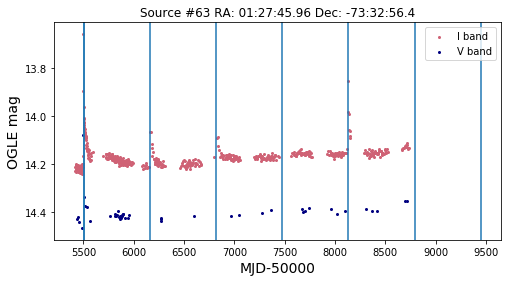

In [79]:
iband,vband = o.getIV(63,cross,stack=True,plot=True)
plt.axvline(5510)
for i in range(7):
    plt.axvline(655.9*i+5510)

(14.3, 13.6)

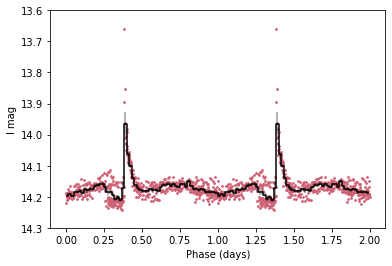

In [80]:
#fold
pd = 655.9
plt.scatter((iband['MJD-50000']%pd)/pd,iband['I mag'],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I mag'],color=pink,s=3)
o.phasestep(iband,pd,60,divide=True)
plt.ylim(14.3,13.6)

(14.3, 13.6)

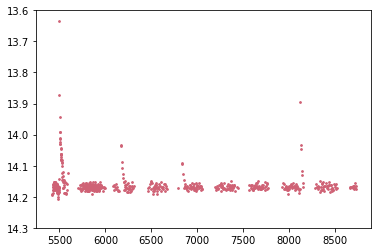

In [81]:
o.splinedetrend(iband,window=300)
plt.scatter(iband['MJD-50000'],iband['I detrend'],color=pink,s=3)
plt.ylim(14.3,13.6)

(14.3, 13.6)

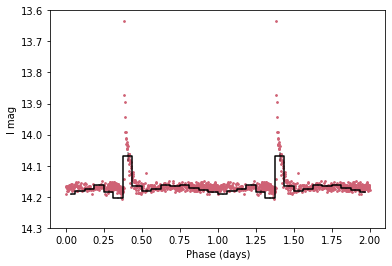

In [82]:
#fold after detrending
pd = 655.9
plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3)
o.phasestep(iband,pd,16,divide=True)
plt.ylim(14.3,13.6)

In [83]:
row = summ[summ['src_n']==63]
row['best period'] = 656
summ[summ['src_n']==63] = row

In [84]:
summ[summ['src_n']==63]['best period']

58    656.0
Name: best period, dtype: float64

In [85]:
srcn = 63
pdict = o.combine(srcn,cross,full,iband=iband,pd=656,pbins=16,det=True,close=True,testbins=False)
row = phase[phase['src_n']==srcn]
#loop through keys in pdict and add quantities to df
for d in list(pdict.keys()):
    row[d] = pdict[d]
phase[phase['src_n']==srcn] = row

### search source #60
393.1 +/- 0.4 Schmidtke et al. 2013

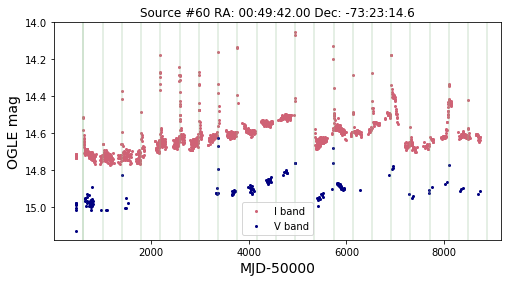

In [86]:
iband,vband = o.getIV(60,cross,stack=True,plot=True)
plt.axvline(625,color='darkseagreen',alpha=0.3)
for i in range(22):
    plt.axvline(393.1*i+625,color='darkseagreen',alpha=0.3)

(15, 14)

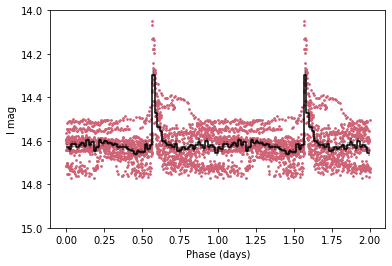

In [87]:
#fold
pd = 393.1
plt.scatter((iband['MJD-50000']%pd)/pd,iband['I mag'],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I mag'],color=pink,s=3)
o.phasestep(iband,393.1,60,divide=True)
plt.ylim(15,14)

**for source like this, amplitude strongly affected by bin number since spike so narrow**

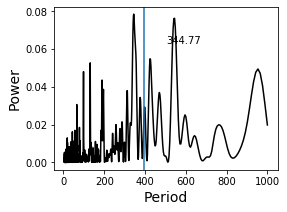

In [88]:
o.periodogram(iband,maxp=1000)
plt.axvline(393) #periodograms just don't really work for this type of source

(15, 14)

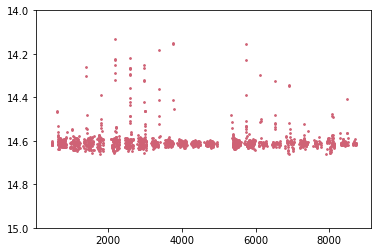

In [89]:
o.splinedetrend(iband,window=300)
plt.scatter(iband['MJD-50000'],iband['I detrend'],color=pink,s=3)
plt.ylim(15,14)

(15, 14)

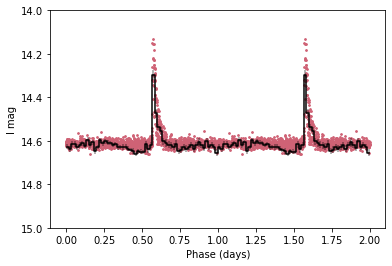

In [90]:
#fold detrended
pd = 393.1
plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3)
o.phasestep(iband,pd,60,divide=True)
plt.ylim(15,14)

In [75]:
row = summ[summ['src_n']==60]
row['best period'] = 393
summ[summ['src_n']==60] = row

# Update phase and summary tables

#### update phase table by using these periods in fold

In [91]:
srcn = 60
pdict = o.combine(srcn,cross,full,iband=iband,pd=393,pbins=16,det=True,close=True,testbins=False)
row = phase[phase['src_n']==srcn]
#loop through keys in pdict and add quantities to df
for d in list(pdict.keys()):
    row[d] = pdict[d]
phase[phase['src_n']==srcn] = row

In [93]:
phase[phase['src_n']==63]

,src_n,period,amp,phase diff,phase max,phase min,shape,diff mean,mean,skew,kurtosis,symm sum,mean err
58,63,656.0,0.104757,0.9375,0.34375,0.40625,not FRED,0.010035,14.162283,-3.571613,10.87291,0.001011,0.002232


In [94]:
phase.to_csv('phasetab.csv',index=False)

In [41]:
summ.to_csv('summtab.csv',index=False)